In [1]:
import tensorflow as tf
# from tensorboard.plugins.hparams import api as hp
from tensorflow import keras

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [27]:
ratings = pd.read_pickle("./Data/reviews_20_1000_longform.pkl")

In [28]:
ratings.drop(index=ratings[ratings.duplicated(keep='first')].index, inplace=True)

In [29]:
ratings.shape

(8854082, 3)

In [30]:
user_enc = LabelEncoder()
ratings['user'] = user_enc.fit_transform(ratings['user_id'].values)
n_users = ratings['user'].nunique()

item_enc = LabelEncoder()
ratings['movie'] = item_enc.fit_transform(ratings['movie_id'].values)
n_movies = ratings['movie'].nunique()

nmovie_id = ratings.movie_id.nunique()
nuser_id = ratings.user_id.nunique()

n_users, n_movies

(64815, 89418)

In [104]:
low_count = len(ratings[(ratings.rating_score==1) | (ratings.rating_score==2)])
high_count = len(ratings[(ratings.rating_score!=1) & (ratings.rating_score!=2)])

In [106]:
(low_count / len(ratings)) * 100

12.692687960197341

In [108]:
initial_bias = np.log([low_count/high_count])

In [140]:
initial_bias

array([-1.92840814])

In [31]:
X_train, X_test = train_test_split(ratings[['movie', 'user', 'rating_score']], test_size=0.3, random_state=42)

In [32]:
X_train.shape, X_test.shape

((6197857, 3), (2656225, 3))

In [112]:
def train_test_model(output_bias):
    
    input_movies = keras.layers.Input(shape=[1])
    embed_movies = keras.layers.Embedding(nmovie_id+1, 15)(input_movies)
    movies_out = keras.layers.Flatten()(embed_movies)

    input_users = keras.layers.Input(shape=[1])
    embed_users = keras.layers.Embedding(nuser_id+1, 15)(input_users)
    users_out = keras.layers.Flatten()(embed_users)

    bias = keras.initializers.Constant(output_bias)
    
    conc_layer = keras.layers.Concatenate()([movies_out, users_out])
    
    dense1 = keras.layers.Dense(128,activation='relu', kernel_regularizer='l2')(conc_layer)
    
    dropout1 = keras.layers.Dropout(rate=.6, seed=42)(dense1)
    
    dense2 = keras.layers.Dense(64,activation='relu', kernel_regularizer='l2')(dropout1)
    
    dropout2 = keras.layers.Dropout(rate=.5, seed=42)(dense2)
    
    dense3 = keras.layers.Dense(32, activation='relu', kernel_regularizer='l2')(dropout2)
    
    dropout3 = keras.layers.Dropout(rate=.4, seed=42)(dense3)
    
    dense4 = keras.layers.Dense(16, activation='relu', kernel_regularizer='l2')(dropout3)
    
    x_out = keras.layers.Dense(1, activation='relu', kernel_regularizer='l2', bias_initializer=bias)(dense3)

    model = keras.Model([input_movies, input_users], x_out)
    
    opt = tf.optimizers.Adam(learning_rate=.01)
    model.compile(optimizer=opt, loss='mean_squared_error', metrics = keras.metrics.RootMeanSquaredError())


#     print(hist.history['val_mean_squared_error'])
    return model

In [110]:
callback = keras.callbacks.EarlyStopping(monitor='val_root_mean_squared_error',
                                        min_delta=.001,
                                        patience=30,
                                        mode="auto",
                                        restore_best_weights=True)

In [115]:
model = train_test_model(output_bias=1)

In [116]:
output = model.fit([X_train.movie, X_train.user], 
             X_train.rating_score,  
             batch_size=len(X_train), epochs=100, validation_split=.2,
                  callbacks=[callback])

Epoch 1/100
1/1 [==============================] - 12s 12s/step - loss: 10.2998 - root_mean_squared_error: 2.9161 - val_loss: 9.3613 - val_root_mean_squared_error: 2.7827
Epoch 2/100
1/1 [==============================] - 9s 9s/step - loss: 9.3217 - root_mean_squared_error: 2.7756 - val_loss: 7.9867 - val_root_mean_squared_error: 2.5535
Epoch 3/100
1/1 [==============================] - 9s 9s/step - loss: 7.9486 - root_mean_squared_error: 2.5461 - val_loss: 5.9392 - val_root_mean_squared_error: 2.1427
Epoch 4/100
1/1 [==============================] - 9s 9s/step - loss: 5.9426 - root_mean_squared_error: 2.1435 - val_loss: 3.4428 - val_root_mean_squared_error: 1.4771
Epoch 5/100
1/1 [==============================] - 9s 9s/step - loss: 3.5803 - root_mean_squared_error: 1.5229 - val_loss: 2.5422 - val_root_mean_squared_error: 1.1588
Epoch 6/100
1/1 [==============================] - 9s 9s/step - loss: 3.1143 - root_mean_squared_error: 1.3838 - val_loss: 3.3310 - val_root_mean_squared_err

1/1 [==============================] - 9s 9s/step - loss: 1.1196 - root_mean_squared_error: 0.9284 - val_loss: 1.0015 - val_root_mean_squared_error: 0.8650
Epoch 50/100
1/1 [==============================] - 9s 9s/step - loss: 1.1085 - root_mean_squared_error: 0.9247 - val_loss: 0.9853 - val_root_mean_squared_error: 0.8578
Epoch 51/100
1/1 [==============================] - 8s 8s/step - loss: 1.0975 - root_mean_squared_error: 0.9209 - val_loss: 0.9722 - val_root_mean_squared_error: 0.8522
Epoch 52/100
1/1 [==============================] - 9s 9s/step - loss: 1.0889 - root_mean_squared_error: 0.9181 - val_loss: 0.9633 - val_root_mean_squared_error: 0.8490
Epoch 53/100
1/1 [==============================] - 9s 9s/step - loss: 1.0835 - root_mean_squared_error: 0.9170 - val_loss: 0.9576 - val_root_mean_squared_error: 0.8477
Epoch 54/100
1/1 [==============================] - 9s 9s/step - loss: 1.0776 - root_mean_squared_error: 0.9157 - val_loss: 0.9544 - val_root_mean_squared_error: 0.8479

1/1 [==============================] - 9s 9s/step - loss: 0.9118 - root_mean_squared_error: 0.8802 - val_loss: 0.8457 - val_root_mean_squared_error: 0.8424
Epoch 98/100
1/1 [==============================] - 8s 8s/step - loss: 0.9097 - root_mean_squared_error: 0.8795 - val_loss: 0.8442 - val_root_mean_squared_error: 0.8421
Epoch 99/100
1/1 [==============================] - 9s 9s/step - loss: 0.9080 - root_mean_squared_error: 0.8792 - val_loss: 0.8432 - val_root_mean_squared_error: 0.8421
Epoch 100/100
1/1 [==============================] - 9s 9s/step - loss: 0.9057 - root_mean_squared_error: 0.8784 - val_loss: 0.8426 - val_root_mean_squared_error: 0.8423


In [119]:
dir(callback)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_chief_worker_only',
 '_implements_predict_batch_hooks',
 '_implements_test_batch_hooks',
 '_implements_train_batch_hooks',
 '_keras_api_names',
 '_keras_api_names_v1',
 '_supports_tf_logs',
 'baseline',
 'best',
 'best_weights',
 'get_monitor_value',
 'min_delta',
 'model',
 'monitor',
 'monitor_op',
 'on_batch_begin',
 'on_batch_end',
 'on_epoch_begin',
 'on_epoch_end',
 'on_predict_batch_begin',
 'on_predict_batch_end',
 'on_predict_begin',
 'on_predict_end',
 'on_test_batch_begin',
 'on_test_batch_end',
 'on_test_begin',
 'on_test_end',
 'on_train_batch_begin',
 'on_train_batch_end',
 'on_train_begin',
 'on_train_end

In [120]:
callback.best

0.8430203199386597

In [121]:
callback.monitor

'val_root_mean_squared_error'

In [122]:
callback.model

In [ ]:
output2 = model.fit([X_train.movie, X_train.user], 
             X_train.rating_score,  
             batch_size=len(X_train), epochs=10, validation_split=.2,
                  callbacks=[callback])

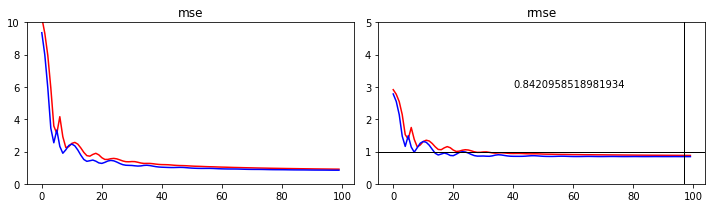

In [117]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 3))


axs[0].plot(output.history['loss'], color='r')
axs[0].plot(output.history['val_loss'], color='b')

axs[1].plot(output.history['root_mean_squared_error'], color='r')
axs[1].plot(output.history['val_root_mean_squared_error'], color='b')
axs[1].axvline(np.where(output.history['val_root_mean_squared_error']==np.min(output.history['val_root_mean_squared_error'])), 
                 color='k', lw=1)
axs[1].annotate(str(np.min(output.history['val_root_mean_squared_error'])),
                    xy=(40,3),)

#     title_str = '-'.join(str(run_history[key]['params'][param]) for param in run_history[key]['params'].keys(),
#                         xytext=(.8,.8), xycoords='subfigure fraction')

axs[0].set_title("mse")
axs[1].set_title("rmse")

axs[0].set_ylim(0,10)
axs[1].set_ylim(0,5)

axs[1].axhline(1, color='k', lw=1)
    
plt.tight_layout()   
plt.show()

In [90]:
len(output.history['loss'])

100

In [91]:
model.trainable_variables

[<tf.Variable 'embedding_14/embeddings:0' shape=(89419, 15) dtype=float32, numpy=
 array([[-0.04060972, -0.0408831 , -0.07540319, ...,  0.05272159,
         -0.01610826,  0.03636319],
        [-0.07631765,  0.01794105, -0.00635751, ..., -0.0513144 ,
         -0.06476335, -0.01258612],
        [-0.02940135, -0.03517935, -0.00887026, ...,  0.12255664,
          0.15908323,  0.02870064],
        ...,
        [ 0.02127912,  0.04027199,  0.00054735, ..., -0.1885152 ,
         -0.03283613, -0.06176513],
        [ 0.01619839,  0.04960533,  0.02113556, ...,  0.09155231,
          0.01556375,  0.04586617],
        [ 0.01719183,  0.03272376, -0.01236945, ...,  0.01487299,
         -0.04141879,  0.04155825]], dtype=float32)>,
 <tf.Variable 'embedding_15/embeddings:0' shape=(64816, 15) dtype=float32, numpy=
 array([[-0.07097471, -0.10677434, -0.12696075, ..., -0.08312505,
         -0.07205073, -0.0492179 ],
        [ 0.0753029 , -0.00496834, -0.00133236, ...,  0.05152988,
          0.0306449 , -0.

In [92]:
!mkdir -p saved_model
model.save('saved_model/rmse_845')

INFO:tensorflow:Assets written to: saved_model/rmse_845/assets


In [93]:
model.save('saved_model/rmse_845/model.h5')

In [94]:
X_train.groupby('rating_score').count()

,movie,user
rating_score,,
1,223618,223618
2,562898,562898
3,1558336,1558336
4,2254707,2254707
5,1598298,1598298


In [63]:
import random
from itertools import chain
def flatten(list_of_lists):
    "Flatten one level of nesting"
    return chain.from_iterable(list_of_lists)

In [95]:
to_drop = []
for rating in [3,4,5]:
    temp_df = X_train[X_train.rating_score==rating]
    to_drop.append(random.choices(temp_df.index, k=int(len(temp_df)*.95)))
    
to_drop = list(flatten(to_drop))

In [96]:
X_train_reduced = X_train.drop(index=to_drop)

In [97]:
X_train.shape, X_train_reduced.shape

((6197857, 3), (2879395, 3))

In [99]:
output_reduced = model.fit([X_train_reduced.movie, X_train_reduced.user], 
                             X_train_reduced.rating_score,  
                             batch_size=len(X_train_reduced), epochs=100, validation_split=.2,
                          callbacks=[callback])

Epoch 1/100
1/1 [==============================] - 5s 5s/step - loss: 1.2243 - root_mean_squared_error: 1.0039 - val_loss: 1.1510 - val_root_mean_squared_error: 0.9668
Epoch 2/100
1/1 [==============================] - 5s 5s/step - loss: 1.2104 - root_mean_squared_error: 0.9970 - val_loss: 1.1557 - val_root_mean_squared_error: 0.9691
Epoch 3/100
1/1 [==============================] - 4s 4s/step - loss: 1.2095 - root_mean_squared_error: 0.9965 - val_loss: 1.1403 - val_root_mean_squared_error: 0.9610
Epoch 4/100
1/1 [==============================] - 5s 5s/step - loss: 1.1970 - root_mean_squared_error: 0.9901 - val_loss: 1.1135 - val_root_mean_squared_error: 0.9468
Epoch 5/100
1/1 [==============================] - 4s 4s/step - loss: 1.1779 - root_mean_squared_error: 0.9802 - val_loss: 1.0990 - val_root_mean_squared_error: 0.9389
Epoch 6/100
1/1 [==============================] - 4s 4s/step - loss: 1.1725 - root_mean_squared_error: 0.9772 - val_loss: 1.1004 - val_root_mean_squared_error:

In [37]:
X_train

,movie,user,rating_score
7200141,16545,33559,5
12173871,134,47103,5
12465191,154,7801,4
14220713,430,30313,4
14278381,453,47719,3
...,...,...,...
13103480,212,38730,4
3382915,3297,8140,4
7663499,20601,45826,5
12216674,136,32716,5


In [38]:
X_train.groupby('user').count().sort_values(by='movie',ascending=False).head()

,movie,rating_score
user,,
28524,734,734
58315,733,733
16167,729,729
49758,728,728
31549,726,726


In [123]:
user = 58315
ratings[ratings.user==user]

,movie_id,rating_score,user_id,user,movie
13381,1085,4,89904558,58315,1038
19800,1094,4,89904558,58315,1047
23850,1099,2,89904558,58315,1052
35843,1103,5,89904558,58315,1056
48584,1116,3,89904558,58315,1069
...,...,...,...,...,...
15428890,981,2,89904558,58315,941
15489675,1046,3,89904558,58315,1002
15493413,1047,2,89904558,58315,1003
15498925,1049,2,89904558,58315,1005


In [124]:
movie_array = ratings[ratings.user==user].movie.values.astype(int)
user_array = np.array([int(user) for n in range(len(movie_array))])

In [125]:
pred = model.predict([movie_array, user_array])

In [42]:
def is_close_enough(pred, ratings):
    val = []
    for pair in zip(pred, ratings):
        if pair[1] == 5:
            val.append(pair[1] - 1 <= pair[0])
        else:
            val.append(pair[1] - .5 <= pair[0] <= pair[1] + .5)
        
    return val

In [126]:
val = is_close_enough(np.round(pred.flatten(), 1), ratings[ratings.user==user].rating_score.values)

In [127]:
sum(val) / len(pred.flatten())

0.5661322645290581

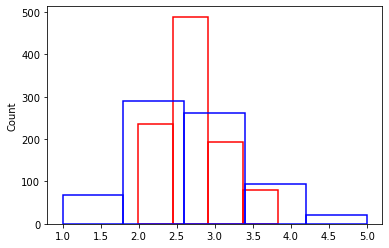

In [130]:
sns.histplot(pred.flatten(), bins=4, color='red', fill=False)
sns.histplot(X_train[X_train.user==user].rating_score.values, bins=5, color='blue', fill=False)

plt.show()

In [129]:
top_20_users = X_train.groupby('user').count().sort_values(by='movie',ascending=False).head(20).index

In [136]:
predictions = []

for user in top_20_users:
    movie_array = X_train[X_train.user==user].movie.values.astype(int)
    user_array = np.array([int(user) for n in range(len(movie_array))])
    pred = model.predict([movie_array, user_array])
    val = is_close_enough(np.round(pred.flatten(), 1), ratings[ratings.user==user].rating_score.values)
    
    predictions.append(list(pred.flatten()))
    print(user, sum(val) / len(pred.flatten()))

28524 0.4673024523160763
58315 0.4120054570259209
16167 0.4993141289437586
49758 0.35027472527472525
31549 0.36363636363636365
18058 0.3623789764868603
7152 0.5877437325905293
60448 0.5678321678321678
22850 0.6489510489510489
39706 0.2654494382022472
17797 0.32724719101123595
24713 0.5850914205344585
26424 0.3563380281690141
39928 0.5070422535211268
64166 0.4076163610719323
29252 0.306064880112835
32438 0.5296610169491526
53545 0.3347457627118644
40384 0.32390381895332393
20035 0.4073550212164074


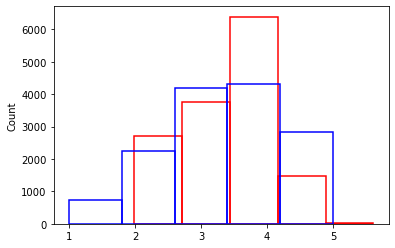

In [139]:
sns.histplot(list(flatten(predictions)), bins=5, color='red', fill=False)
sns.histplot(X_train[X_train.user.isin(top_20_users)].rating_score.values, bins=5, color='blue', fill=False)

plt.show()